In [ ]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
import seaborn as sns
from IPython import display

import imageio 
import time
from tensorflow.keras import layers
from keras import backend

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Importing data
data_path = "/content/drive/MyDrive/Data_science/abstract-art-gallery/Abstract_gallery/Abstract_gallery"
batch_s = 256
#Import as tf.Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 2782 files belonging to 1 classes.


Visualizing some of the pics

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
    
#     plt.axis("off")

Normalizing to [-1, 1]

In [ ]:
# for image_batch in train_ds:
#   print(image_batch.shape)
#   break

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda t: normalization_layer(t))

In [ ]:
# image_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# print(np.min(first_image), np.max(first_image))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
normalized_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Generator

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((4, 4, 1024)))

    assert model.output_shape == (None, 4, 4, 1024)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))


    model.add(layers.Conv2DTranspose(128, (5, 5), strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)
    model.add(layers.Activation("tanh"))
    
    return model

testing the generator

# Discriminator

In [ ]:

# from keras.constraints import Constraint
# from keras.initializers import RandomNormal


# class ClipConstraint(Constraint):
# 	# set clip value when initialized
# 	def __init__(self, clip_value):
# 		self.clip_value = clip_value
 
# 	# clip model weights to hypercube
# 	def __call__(self, weights):
# 		return backend.clip(weights, -self.clip_value, self.clip_value)
 
# 	# get the config
# 	def get_config(self):
# 		return {'clip_value': self.clip_value}

In [ ]:
# disc_constraint = ClipConstraint(0.03)
# init = RandomNormal(stddev=0.04)

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    #
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, input_shape=(64,64,3), padding="same"))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding="same"))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(256, kernel_size=5, strides=2, padding="same"))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(512, kernel_size=5, strides=1, padding="same"))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Dropout(0.05))

    # model.add(layers.GaussianNoise(0.1)) ###########
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='linear'))

    return model

# GAN model

In [ ]:
class GAN:
  def __init__(self):
    self.discriminator = make_discriminator_model()
    self.generator = make_generator_model()

    self.cross_entropy = tf.keras.losses.BinaryCrossentropy() 

    self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
    self.discriminator_optimizer = tf.keras.optimizers.RMSprop(0.0005)
    self.batch_size = batch_s
    self.noise_dim = 100
    self.learning_ratio = 1
    self.gp_weight = 10

    
    self.checkpoint_dir = './training_checkpoints'
    self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
    self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                    discriminator_optimizer=self.discriminator_optimizer,
                                    generator=self.generator,
                                 discriminator=self.discriminator)

    
    # print(self.discriminator.summary())
    # print(self.generator.summary())
  
  def discriminator_loss(self, real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    return -(fake_loss - real_loss) ##

  def generator_loss(self, fake_output):
    return tf.reduce_mean(fake_output) ##

  def gradient_penalty(self, real_images, fake_images):
      """Calculates the gradient penalty.

      This loss is calculated on an interpolated image
      and added to the discriminator loss.
      """
      # Get the interpolated image
      alpha = tf.random.normal([real_images.shape[0], 1, 1, 1], 0.0, 1.0)
      diff = fake_images - real_images
      interpolated = real_images + alpha * diff

      with tf.GradientTape() as gp_tape:
          gp_tape.watch(interpolated)
          # 1. Get the discriminator output for this interpolated image.
          pred = self.discriminator(interpolated, training=True)

      # 2. Calculate the gradients w.r.t to this interpolated image.
      grads = gp_tape.gradient(pred, [interpolated])[0]
      # 3. Calculate the norm of the gradients.
      norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
      gp = tf.reduce_mean((norm - 1.0) ** 2)
      return gp



  @tf.function # Compiles a function into a callable TensorFlow graph
  def train_step(self, images, train_generator_state):
      noise = tf.random.normal([images.shape[0], self.noise_dim])

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = self.generator(noise, training=train_generator_state)

        real_output = self.discriminator(images, training=True)
        fake_output = self.discriminator(generated_images, training=True)

        gen_loss = self.generator_loss(fake_output)
        disc_loss = self.discriminator_loss(real_output, fake_output)
      
        gp = self.gradient_penalty(images, generated_images)

        disc_loss = disc_loss + gp * self.gp_weight
     
      gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
      self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

      if train_generator_state:
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

      return gen_loss, disc_loss

  def train(self, dataset, epochs, print_seed):
    gen_mean_history = []
    disc_mean_history = []

    gen_mean_object = tf.metrics.Mean()
    disc_mean_object = tf.metrics.Mean()

    for epoch in range(epochs):
      start = time.time()
      counter = 0
      train_generator_state = False
      gen_mean_object = tf.metrics.Mean()
      disc_mean_object = tf.metrics.Mean()
      dataset = dataset.shuffle(500)
      for image_batch in dataset:
        if counter % self.learning_ratio == 0:
          train_generator_state = True
        else:
          train_generator_state = False
          
        gen_loss, disc_loss = self.train_step(image_batch, train_generator_state)
        

        counter = counter + 1

        gen_mean_object.update_state(gen_loss)
        disc_mean_object.update_state(disc_loss)
      
      gen_mean_history.append(gen_mean_object.result().numpy())
      disc_mean_history.append(disc_mean_object.result().numpy())
      

      gen_mean_object.reset_state()
      disc_mean_object.reset_state()
      
      # Produce images for the GIF as you go
      display.clear_output(wait=True)
      self.generate_and_save_images(
                              epoch + 1,
                              print_seed)
      
      print("epoch = {}".format(epoch+1))
      print('generator mean loss = {} '.format(gen_mean_history[epoch]))
      print('discriminator mean loss = {} '.format(disc_mean_history[epoch]))
      

      # Save the model every 15 epochs

      if (epoch + 1) % 15 == 0:
        self.checkpoint.save(file_prefix = self.checkpoint_prefix)

      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)

    self.generate_and_save_images(
                            epochs,
                            print_seed)
    
    return gen_mean_history, disc_mean_history
    
  def generate_and_save_images(self, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = self.generator(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

  


In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)




In [ ]:
gan_model = GAN()
print_seed = tf.random.normal([num_examples_to_generate, noise_dim])

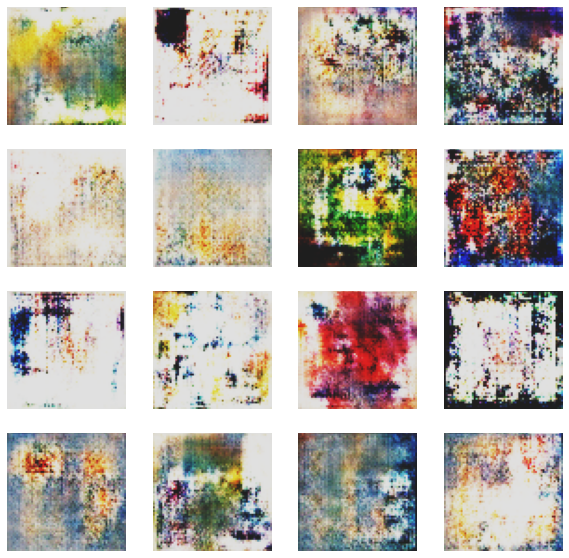

In [ ]:
gen_mean_history, disc_mean_history = gan_model.train(normalized_ds, EPOCHS, print_seed)

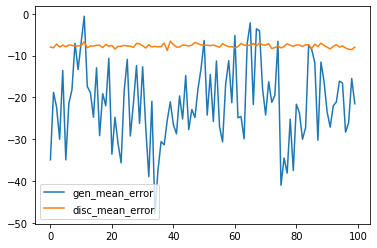

In [ ]:
plt.figure()
plt.plot(gen_mean_history)
plt.plot(disc_mean_history)
plt.legend(("gen_mean_error", "disc_mean_error"))
plt.show()

In [ ]:
# from google.colab import files
# os.system( "zip -r {} {}".format("ckpt-9.zip", "/content/training_checkpoints/ckpt-9.data-00000-of-00001"))
# files.download("ckpt-9.zip")

# Wasserstein Loss